# Poisson Confidence Intervals: Feldman-Cousins Ordering
 >__Created__:  21 October 2021 Harrison B. Prosper<br>
 > for LPC Stats 2021

## Introduction
The frequentist principle (Neyman, 1937) requires the following guarantee:

In an infinite ensemble of statements not necessarily about the same thing it is guaranteed that a minimum fraction of them, called the __confidence level__, are true.

The standard application of this principle is the construction of confidence intervals $[\, \mu_L(X), \mu_U(X) \,]$ and statements of the form $$\mu \in [\, \mu_L(X), \mu_U(X) \,],$$
where $X$ is a random variable.

## Feldman-Cousins Method
In 1998, Gary Feldman and Robert Cousins$^1$ introduced a method to construct intervals that respect the frequentist principle. This notebook uses this method to illustrate the general procedure for constructing cconfidence intervals using the F-C method as an example.

  1. Gary J. Feldman and Robert D. Cousins, *Unified approach to the classical statistical analysis of small signals*, Phys. Rev. D __57__, 3873, 1998.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#from gammapy.stats import significance_on_off
from gammapy.stats import CashCountsStatistic

"""
from gammapy.stats import (
    fc_construct_acceptance_intervals_pdfs,
    fc_get_limits,
    fc_fix_limits,
)
"""

'\nfrom gammapy.stats import (\n    fc_construct_acceptance_intervals_pdfs,\n    fc_get_limits,\n    fc_fix_limits,\n)\n'

In [2]:
stat = CashCountsStatistic(n_on=13, mu_bkg=5.5)
print(f"Excess  : {stat.n_sig:.2f}")
print(f"Error   : {stat.error:.2f}")
print(f"TS      : {stat.ts:.2f}")
print(f"sqrt(TS): {stat.sqrt_ts:.2f}")
print(f"p-value : {stat.p_value:.4f}")

Excess  : 7.50
Error   : 3.61
TS      : 7.37
sqrt(TS): 2.71
p-value : 0.0033


In [3]:
count_statistic = CashCountsStatistic(n_on=13, mu_bkg=5.5)
excess = count_statistic.n_sig
errn = count_statistic.compute_errn(1.)
errp = count_statistic.compute_errp(1.)
print(f"68% confidence range: {excess + errn:.3f} < mu < {excess + errp:.3f}")

68% confidence range: 4.220 < mu < 11.446


In [4]:
errn_2sigma = count_statistic.compute_errn(2.)
errp_2sigma = count_statistic.compute_errp(2.)
print(f"95% confidence range: {excess + errn_2sigma:.3f} < mu < {excess + errp_2sigma:.3f}")

95% confidence range: 1.556 < mu < 16.102


In [156]:
# standard system modules
import os, sys

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt

# arbitrary precision real and complex calculation
#import mpmath

# make plots appear inline
%matplotlib inline

In [157]:
# update fonts
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18
        }
mp.rc('font', **font)
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Find an interval in the space of observations
We start at $\mu \approx 0$ with the lower boundary at $n_1 = 0$.
  1. Define a window from $n_1$ to $n_2$, where $n_2 = n_1 + \text{int}(6 \sqrt{\mu})$.
  1. Compute the ratios $r_n = \text{Poisson}(n, \mu) \, / \,  \text{Poisson}(n, \hat{\mu})$ $ = \mu^n \exp(-\mu) \, / \, n^n \exp(-n)$.
  1. Sort $r_n$ in descending order such that $n_{(1)}$ corresponds to the count with the largest value of $r_n$, $n_{(2)}$ to the second largest value and so on.
  1. Compute the sum $p = \text{Poisson}(n_{(1)}, \mu) + \text{Poisson}(n_{(2)}, \mu) + \ldots$ and stop when the sum equals or just exceeds the desired confidence level, CL.
  1. For each $n$ in the set $\{ n_{(i)} \}$ cache the value of $\mu$.
  1. Set $n_1 = n_{(1)}$ and repeat the above for $\mu \leftarrow \mu + \Delta \mu$.

In [158]:
#CL    = 0.683
CL    = 0.95
#MUMIN =  0
MUMIN =  -5
#MUMAX = 25
MUMAX = 7
MUSTEP= 0.01
#MUSTEP= 0.001

In [180]:
def compute_obs_interval(mu, n1, cache, cl):
    
    # step 1: define range to scan
    n2 = n1 + int(6*np.sqrt(mu))
    
    # steps 2, 3: compute ratios and sort
    rn = []
    
    for n in range(n1, n2+1) :
        #p = st.poisson.pmf(n, mu) # norm.pdf(x, loc, scale) 
        #q = st.poisson.pmf(n, n)
        if (n>0):
            p = st.norm.pdf(n, mu)
            q = st.norm.pdf(0)
            rn.append((p / q, p, n))
        if (n<=0):
            p = st.norm.pdf(n, mu)
            q = st.norm.pdf(n)
            rn.append((p / q, p, n))
    rn.sort()
    rn.reverse()

    # step 4: cache mu for every n in interval
    m = []
    p = 0.0
    for _, pn, n in rn:
        if n not in cache:
            cache[n] = []
        cache[n].append(mu)
        m.append(n)
        p += pn
        if p >= cl:
            break
            
    # check that counts are contiguous
    m.sort()
    m  = np.array(m)
    n1 = m.min()
    n2 = m.max()
    
    # u =  n1 + ... + n2 + n2 + ... + n1
    # u = len(m)*(n1+n2)
    u = (np.arange(n1,n2+1) + np.arange(n2,n1-1,-1)).sum()
    w = len(m) * (n1 + n2)
    if u != w:
        print('** non-contiguous interval: %s\tmu = %5.2f' % (m, mu))

    return (p, n1, n2)
    #return (p, n1, n2, mu)

In [181]:
#print(f"N: {int(1.5*(MUMAX-MUMIN)/MUSTEP):f}")
l = [1,2,3,4,5]
#print(l[:-1])
print(st.norm.pdf(0))

0.3989422804014327


### Confidence Intervals
Every count $n$ is associated with a range of values of $\mu$. Find the range of values and define the confidence interval to be the lower and upper bound of the $\mu$ values for each $n$.

In [191]:
def compute_intervals(cl, 
                      mumin=MUMIN, mumax=MUMAX, mustep=MUSTEP):
    # mumin:  minimum mean value
    # mumax:  maximum mean value
    # mustep: step in mean value

    # number of points in mu at which to construct an interval in
    # the space of counts.
    N = int(1.5*(mumax-mumin)/mustep)
    

    # cache the value of mu associated with each count.
    # the lower and upper limits of the confidence interval
    # associated with a count are just the minimum and
    # maximum values of mu for a given count.
    cache = {}

    mu = [] # mu values
    p  = [] # coverage probability
    #n1 = 0  # lower bound of interval in space of observations
    n1 = -5  # lower bound of interval in space of observations

    for i in range(N):
        x = (i+1) * mustep
        q, n1, n2 = compute_obs_interval(x, n1, cache, cl)
        #q, n1, n2, xmu = compute_obs_interval(x, n1, cache, cl)
        
        # accumulate coverage vs. mu
        if x <= mumax:
            #if i % 5 == 0:
            if i % 0.1 == 0:
                mu.append(x)
                p.append(q)
        #if i % 500 == 0:
        if i % 500 == 0:
            print('%10.1f %10.3f %5d %5d' % (x, q, n1, n2))
        
    # get confidence intervals
    intervals = []
    for n in range(mumax+1):
    #for n in range(n1, mumax+1):
        lower = min(cache[n])
        upper = max(cache[n])
        intervals.append((lower, upper))
    return (intervals, mu, p)

In [192]:
intervals, mu, p = compute_intervals(CL)
print(intervals[0:4])
print(mu[0:4])
print(p[0:4])

       0.0      0.000    -5    -5
       5.0      0.991     3     7
      10.0      0.991     8    12
      15.0      0.991    13    17
[(0.7000000000000001, 2.14), (1.0, 3.14), (1.37, 4.14), (1.78, 5.14)]
[0.01]
[1.4141406395950037e-06]


### Plot coverage vs. mean count $\mu$

In [193]:
def plot_coverage(x, y, cl,
                  xmin=MUMIN, xmax=MUMAX, 
                  ymin=0, ymax=1, 
                  ftsize=20, 
                  fgsize=(6, 5)):
   
    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points 
    plt.plot(x, y, color='steelblue', 
             label='Feldman-Cousins intervals')
    
    percent = '%s' % '%'
    icl = int(100*cl)
    plt.plot([xmin, xmax], [cl, cl], 
             color='magenta',linestyle='--', 
             label='CL = %5.3f' % cl)

    # add legends 
    plt.legend(fontsize=18)
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel(r'$\mu$', fontsize=ftsize)
    plt.ylabel(r'Pr[$\,\mu \in (\mu_L, \, \mu_U)\,$]', 
               fontsize=ftsize)
 
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    
    filename = "fig_poisson_FC_coverage_%2.2d.pdf" % icl
    print(filename)
    plt.savefig(filename)
    plt.show()

In [194]:
import os
print(os.environ['PATH'])

/Users/akhanal/opt/anaconda3/envs/clas12_analysis/bin:/Users/akhanal/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin:/Library/Apple/usr/bin


fig_poisson_FC_coverage_95.pdf


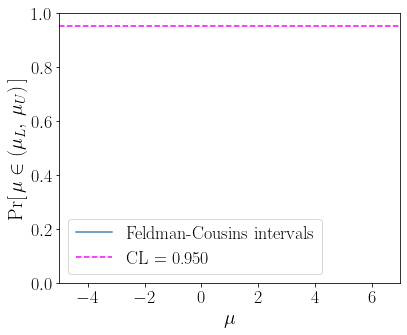

In [195]:
plot_coverage(mu, p, CL)

In [196]:
def plot_intervals(intervals, cl, 
                   xmin=MUMIN, xmax=MUMAX, 
                   ymin=0, ymax=MUMAX, 
                   ftsize=20, 
                   fgsize=(6, 5)):

    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points
    for n, y in enumerate(intervals[:-1]):
        x = (n, n)
        if n < 10:
            print('%5d %5.2f, %5.2f' % (n, y[0], y[1]))
        plt.plot(x, y, color='steelblue', linewidth=2)
    n = len(intervals)
    x = (n, n)
    y = intervals[-1]
    #plt.plot(x, y, color='steelblue', linewidth=2, label='%5.3f CL F-C intervals' % cl)
    
    # add legends 
    #plt.legend()
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel(r'$N$', fontsize=ftsize)
    plt.ylabel(r'$[\,\mu_L(N), \, \mu_U(N)\,]$', 
               fontsize=ftsize)
 
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    
    icl = int(100*cl)
    filename = "fig_poisson_FC_intervals_%d.pdf" % icl
    print(filename)
    plt.savefig(filename)
    plt.show()

    0  0.70,  2.14
    1  1.00,  3.14
    2  1.37,  4.14
    3  1.78,  5.14
    4  1.86,  6.14
    5  2.86,  7.14
    6  3.86,  8.14
fig_poisson_FC_intervals_95.pdf


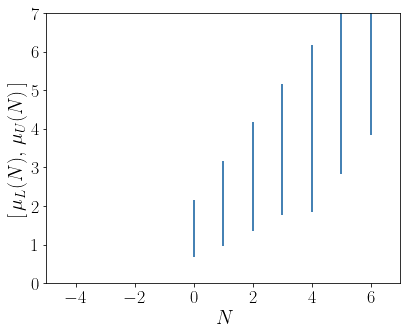

In [197]:
plot_intervals(intervals, CL)